In [1]:
import importlib

import os
import clip
import torch
from torchvision import transforms, models

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import argparse
from omegaconf import OmegaConf

import json

device = "cuda" if torch.cuda.is_available() else "cpu"
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import seaborn as sn

from columnar import columnar
from nltk.corpus import wordnet as wn
clip_model, clip_preprocess = clip.load("ViT-B/32", )


import datasets #import the module here, so that it can be reloaded.
importlib.reload(datasets)
from datasets import *


In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nethome/bdevnani3/anaconda3/envs/p3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
template_performance = {}

In [3]:
dataset_obj = SmallFlowers102(4, 1)
train_loader, _ = dataset_obj.get_train_loaders(transform_fn=clip_preprocess)
test_loader = dataset_obj.get_test_loader(transform_fn=clip_preprocess)

In [4]:
def clip_zero_shot(
    loader,
    classes,
    zeroshot_weights,
    clip_model_name="ViT-B/32",
):

    global clip_model, clip_preprocess
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def accuracy(output, target, topk=(1,)):
        pred = output.topk(max(topk), 1, True, True)[1].t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return [
            float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy())
            for k in topk
        ]

    # lazy load
    if clip_model == None:
        clip_model, clip_preprocess = clip.load(clip_model_name, device)
        
    per_class_accuracy_top1 = { k:[0,0, classes[k]] for k in range(len(classes))} # correct, total, class_name
    per_class_accuracy_top5 = { k:[0,0, classes[k]] for k in range(len(classes))} 

    with torch.no_grad():
        top1, top5, n = 0.0, 0.0, 0.0
        for i , (images, target) in enumerate(tqdm(loader)):
            images = images.cuda()
            target = target.cuda()

            # predict
            image_features = clip_model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ zeroshot_weights

            # measure accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1 += acc1
            top5 += acc5
            n += images.size(0)
            
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][0]+= acc1
            per_class_accuracy_top1[target.cpu().detach().numpy()[0]][1]+= 1

    top1 = (top1 / n) * 100
    top5 = (top5 / n) * 100

    return top1, per_class_accuracy_top1

### Baseline

In [5]:
phrase_file = "/nethome/bdevnani3/vis_lang/efficient_finetuning/configs/phrases/flowers.txt"

templates = ["{}"]
    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

baseline_zw = zeroshot_classifier(dataset_obj.classes,templates)

baseline_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    baseline_zw
)
print(baseline_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

44.44444444444444


0.6959952485193894


<AxesSubplot:>

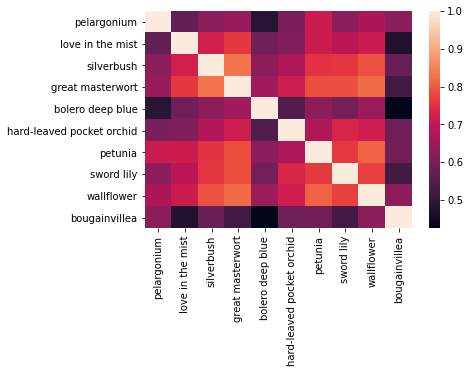

In [6]:
matrix = cosine_similarity(baseline_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

In [7]:
def per_class_performance(d, print_out=True):
    x = []
    labels = []
    corr = []
    tot = []
    for el in d:
        x.append((d[el][0]*100)/d[el][1])
        labels.append(d[el][2])
        corr.append(d[el][0])
        tot.append(d[el][1])
    idx = np.argsort(x)
    x = np.array(x)[idx]
    labels = np.array(labels)[idx]
    corr = np.array(corr)[idx]
    tot = np.array(tot)[idx]
    out = {}
    for l,per,c,t in zip(labels,x,corr,tot):
        out[l] = [np.around(per,5),int(c),int(t)]
    if print_out:
        table = columnar([[l, o[0], o[1], o[2]] for l,o in out.items()], ["Class Name", "Accuracy(%)", "Num Correct", "Total"])
        print(table)
    return out
baseline_pcp = per_class_performance(baseline_czs[1])

|-------------------------|-----------|-----------|-----|
|Class Name               |Accuracy(%)|Num Correct|Total|
|=======================================================|
|love in the mist         |0.0        |0          |31   |
|-------------------------|-----------|-----------|-----|
|bolero deep blue         |0.0        |0          |33   |
|-------------------------|-----------|-----------|-----|
|silverbush               |16.66667   |7          |42   |
|-------------------------|-----------|-----------|-----|
|sword lily               |23.0       |23         |100  |
|-------------------------|-----------|-----------|-----|
|pelargonium              |25.0       |14         |56   |
|-------------------------|-----------|-----------|-----|
|petunia                  |31.06796   |64         |206  |
|-------------------------|-----------|-----------|-----|
|wallflower               |54.14013   |85         |157  |
|-------------------------|-----------|-----------|-----|
|great masterw

## Exploring qualities of templates

### Single template exploration

In [13]:
templates = ["{}", "a {}", 
             "is a {}", 
             "this is a {}", 
             "This is a {}.", 
             "This is a photo of a {}.",
             'This is a photo of a {}, a kind of flower.',
             'a photo of many {}.',
             'a beautiful {}',
             'many beautiful {}',
             'many beatiful {}',
             'a flower of type: {}',
             'a {} with leaves.',
             'a {} with petals.']


for template in templates:
    if template in template_performance:
        continue
    zw = zeroshot_classifier(dataset_obj.classes,[template])

    czs = clip_zero_shot(
        train_loader,
        dataset_obj.classes,
        zw
    )
    template_performance[template] = czs[0]
    
template_performance

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

{'{}': 44.44444444444444,
 'a {}': 56.776556776556774,
 'is a {}': 41.02564102564102,
 'this is a {}': 11.477411477411477,
 'This is a {}.': 12.21001221001221,
 'This is a photo of a {}.': 22.1001221001221,
 'This is a photo of a {}, a kind of flower.': 35.775335775335776,
 'a photo of many {}.': 32.356532356532355,
 'a beautiful {}': 31.37973137973138,
 'many beautiful {}': 36.26373626373626,
 'many beatiful {}': 36.75213675213676,
 'a flower of type: {}': 32.234432234432234,
 'a {} with leaves.': 28.69352869352869,
 'a {} with petals.': 33.943833943833944}

Some key observations:

- "a" made a really big difference to the accuracy
- Spelling mistakes don't seem to hurt perpormance much.
- Potential bias towards visually available objects (leaves, petals)

### Combination of templates exploration


In [14]:
templates = [["a {} with leaves"],
             ["a {} with petals"],
             ['a {} with leaves.',
             'a {} with petals.'],
             ['a {} with leaves and petals.'],
            ['{}'],
            ['a {} with a number of green leaves and a number of beautiful petals.']]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


nt = {}
for i, template in enumerate(templates):
    zw = zeroshot_classifier(dataset_obj.classes,template)

    czs = clip_zero_shot(
        train_loader,
        dataset_obj.classes,
        zw
    )
    nt[i] = [template, czs[0]]
    print(czs[0])
    
nt

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

65.07936507936508


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

67.52136752136752


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

68.00976800976801


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

70.6959706959707


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

44.44444444444444


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

68.25396825396825


{0: [['a {} with leaves'], 65.07936507936508],
 1: [['a {} with petals'], 67.52136752136752],
 2: [['a {} with leaves.', 'a {} with petals.'], 68.00976800976801],
 3: [['a {} with leaves and petals.'], 70.6959706959707],
 4: [['{}'], 44.44444444444444],
 5: [['a {} with a number of green leaves and a number of beautiful petals.'],
  68.25396825396825]}

Some key observations:

- Incorporating multiple signals in the same sentence seems to work better than averaging over multiple sentence embeddings.

In [19]:
templates = [["{} leaves petals"]]

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


nt = {}
for i, template in enumerate(templates):
    zw = zeroshot_classifier(dataset_obj.classes,template)

    czs = clip_zero_shot(
        train_loader,
        dataset_obj.classes,
        zw
    )
    nt[i] = [template, czs[0]]
    print(czs[0])
    
nt

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

67.15506715506714


{0: [['{} leaves petals'], 67.15506715506714]}

## Incorporating class attributes


### Color descriptors

In [15]:
colors = {
     'pelargonium': ["violet", "lavender"],
     'love in the mist': ["white", "blue", "purple"],
     'silverbush': ["white", "yellow"],
     'great masterwort': ["white", "pink", "magenta"],
     'bolero deep blue': ["purple", "lavender", "violet"],
     'hard-leaved pocket orchid': ["white", "pink", "lavender"],
     'petunia': ["white", "red", "pink"],
     'sword lily': ["red", "pink", "white"],
     'wallflower': ["red", "yellow", "orange"],
     'bougainvillea': ["purple", "violet", "pink", "white"],}

In [16]:
templates = ["a {} flower with {} petals."]

    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in colors[classname]:
                texts.extend([
                    template.format(classname, color) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

75.45787545787546


In [12]:
templates = ["a {} {} flower."]

    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            for color in colors[classname]:
                texts.extend([
                    template.format(color, classname) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

colors_zw = zeroshot_classifier(dataset_obj.classes,templates)

colors_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    colors_zw
)
print(colors_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

75.94627594627595


0.7023736448021353


<AxesSubplot:>

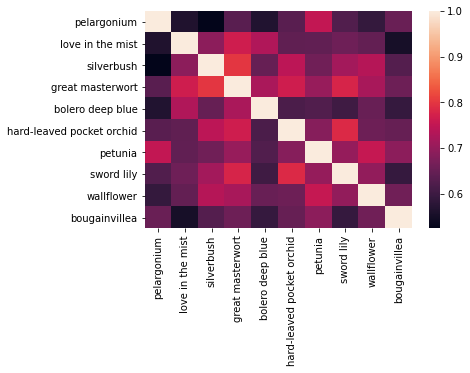

In [20]:
matrix = cosine_similarity(colors_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

### Other names


In [ ]:
other_names = {
     'pelargonium': ["geranium", "storksbill"],
     'love in the mist': ["ragged lady", "devil in the bush", ],
     'silverbush': ["shrubby bindweed", "Convolvulus cneorum"],
     'great masterwort': ["Astrantia major"],
     'bolero deep blue': ["Texas bluebell", "bluebell", "showy prairie gentian", "prairie gentian"],
     'hard-leaved pocket orchid': ["silver slipper orchid", "paphiopedilum micranthum"],
     'petunia': ["Grandiflora", "Multiflora", "Cascadia"],
     'sword lily': ["Gladiolus"],
     'wallflower': ["Erysimum"],
     'bougainvillea': ["paper flower", "bougainvillia"],}

In [21]:
other_names = {
     'pelargonium': ["geranium"],
     'love in the mist': ["ragged lady" ],
     'silverbush': ["Convolvulus cneorum"],
     'great masterwort': ["Astrantia major"],
     'bolero deep blue': ["prairie gentian"],
     'hard-leaved pocket orchid': ["paphiopedilum micranthum"],
     'petunia': ["Cascadia"],
     'sword lily': ["Gladiolus"],
     'wallflower': ["Erysimum"],
     'bougainvillea': ["bougainvillia"],}

In [49]:
templates = ["a {} flower, also called {} flower."]

    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = []
            all_names = other_names[classname]
            for c in all_names:
                texts.extend([
                    template.format(classname, c) for template in templates
                ])  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(texts)  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

names_zw = zeroshot_classifier(dataset_obj.classes,templates)

names_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    names_zw
)
print(names_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

76.55677655677655


0.6109125784149995


<AxesSubplot:>

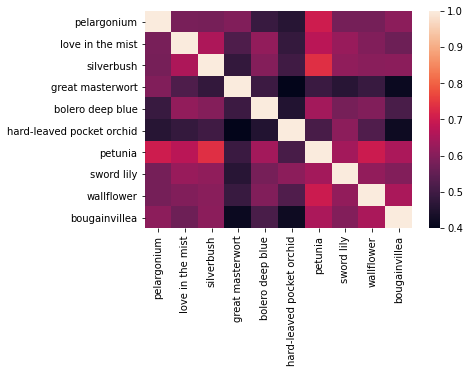

In [23]:
matrix = cosine_similarity(names_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

Observations

- Oddly enough, providing one alternate name seems to be working equally as well as providing multiple, nothing new is learnt

### Non visual descriptors


In [24]:
non_visual_descriptions = {
     'pelargonium': ["{} is an evergreen plant.", "{} is a perennial.", "{} has five petals."],
     'love in the mist': ["{} has pinnately divided, thread-like, alternate leaves", "{} blooms in early summer"],
     'silverbush': ["{} is an evergreen shrub." , "{} is found in coastal areas"],
     'great masterwort': ["{}'s stem is erect and glabrous.", "{} produces an essential oil."],
     'bolero deep blue': ["{} has been cultivated in japan for many years.", "{} prefers moist sandy soils."],
     'hard-leaved pocket orchid': ["{} has no fragrance.", "{} is found commonly in China."],
     'petunia': ["{} is an annual flower.", "{} are insect pollinated."],
     'sword lily': ["{}s grow from round, symmetrical corms.", "{} were originally pollinated by long-tongued anthophorini bees."],
     'wallflower': ["The leaves of {} are narrow and sessile.", "Flowering for the {} occurs during spring and summer."],
     'bougainvillea': [" The {} consists of large colourful sepal-like bracts which surround three simple waxy flowers."],}

In [25]:
templates = []

    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        
        for classname in tqdm(classnames):
            templates = non_visual_descriptions[classname]
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(
                texts
            )  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

desc_zw = zeroshot_classifier(dataset_obj.classes,templates)

desc_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    desc_zw
)
print(desc_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

66.30036630036629


0.6821450622295204


<AxesSubplot:>

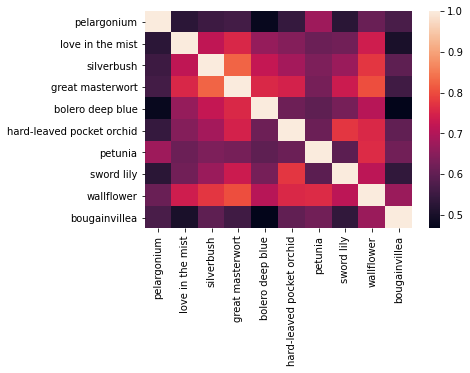

In [26]:
matrix = cosine_similarity(desc_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

### Visual Descriptions

In [27]:
visual_descriptions = {
     'pelargonium': ["{} has five-petaled flowers in umbel-like clusters.", "{} open from the centre outwards, this is a form of inflorescence is referred to as pseudoumbels"],
     'love in the mist': ["{} has pinnately divided, thread-like, alternate leaves", "For {}, the four to five carpels of the compound pistil have each an erect style"],
     'silverbush': ["{} has a yellow throat."],
     'great masterwort': ["{} has long stamens.", "{} has five petaled leaves."],
     'bolero deep blue': ["{} has blue-green waxy leaves.", "{} has showy bell shaped flowers in blue pink or white."],
     'hard-leaved pocket orchid': ["{} has red veins.", "{} has large white petals."],
     'petunia': ["{} is a round flower."],
     'sword lily': ["the {} flower spikes are large and one-sided." ],
     'wallflower': ["{} is characterised by sessile, stellate (star-shaped) and/or malpighiaceous (two-sided) trichomes, yellow to orange flowers"],
     'bougainvillea': ["{} has three flowers is surrounded by three or six bracts", "{} occur in groups"]}

In [28]:
templates = []

    
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        
        for classname in tqdm(classnames):
            templates = visual_descriptions[classname]
            texts = [
                template.format(classname) for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(
                texts
            )  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

vis_desc_zw = zeroshot_classifier(dataset_obj.classes,templates)

vis_desc_czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    vis_desc_zw
)
print(vis_desc_czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

61.66056166056166


0.6093670945967934


<AxesSubplot:>

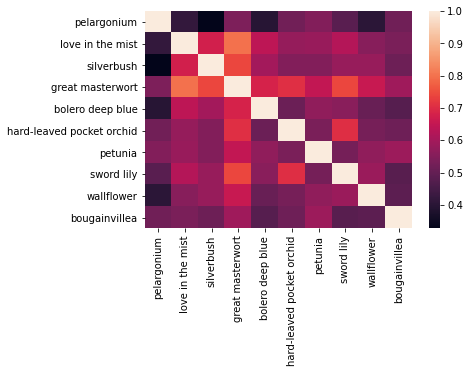

In [29]:
matrix = cosine_similarity(vis_desc_zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)

### Putting it all together

In [43]:
final_templates = {}
for c in dataset_obj.classes:
    final_templates[c] = []
    cs = ""
    for color in colors[c]:
        cs+= f" {color},"
    cs = cs[:-1]
    sen = f"{c} also known as {other_names[c][0]} has {cs} petals"
    final_templates[c] = [sen]
    
final_templates

{'pelargonium': ['pelargonium also known as geranium has  violet, lavender petals'],
 'love in the mist': ['love in the mist also known as ragged lady has  white, blue, purple petals'],
 'silverbush': ['silverbush also known as Convolvulus cneorum has  white, yellow petals'],
 'great masterwort': ['great masterwort also known as Astrantia major has  white, pink, magenta petals'],
 'bolero deep blue': ['bolero deep blue also known as prairie gentian has  purple, lavender, violet petals'],
 'hard-leaved pocket orchid': ['hard-leaved pocket orchid also known as paphiopedilum micranthum has  white, pink, lavender petals'],
 'petunia': ['petunia also known as Cascadia has  white, red, pink petals'],
 'sword lily': ['sword lily also known as Gladiolus has  red, pink, white petals'],
 'wallflower': ['wallflower also known as Erysimum has  red, yellow, orange petals'],
 'bougainvillea': ['bougainvillea also known as bougainvillia has  purple, violet, pink, white petals']}

In [44]:
templates = []

def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        
        for classname in tqdm(classnames):
            templates = final_templates[classname]
            texts = [
                template for template in templates
            ]  # format with class
            texts = clip.tokenize(texts).cuda()  # tokenize
            class_embeddings = clip_model.encode_text(
                texts
            )  # embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights

zw = zeroshot_classifier(dataset_obj.classes,templates)

czs = clip_zero_shot(
    train_loader,
    dataset_obj.classes,
    zw
)
print(czs[0])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/819 [00:00<?, ?it/s]

77.65567765567766


0.5369013124339506


<AxesSubplot:>

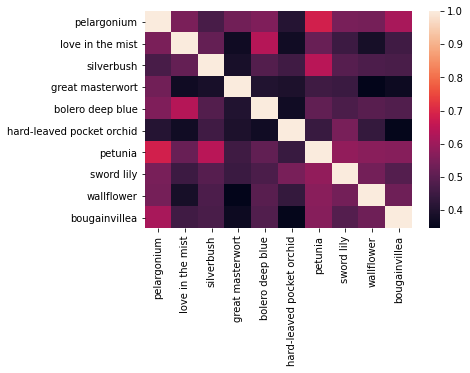

In [45]:
matrix = cosine_similarity(zw.cpu().detach().numpy().T)
print(matrix.mean())
sn.heatmap(matrix, xticklabels = dataset_obj.classes, yticklabels = dataset_obj.classes)